Pro. Fernando Amaral  -  [www.eia.ai](https://www.eia.ai)

In [ ]:
#GPU

In [2]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms,datasets
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hiper Parâmetros
latent_dim = 128
channels = 1
img_size = 28

lr = 0.0002
b1 = 0.5
b2 = 0.999

batch_size = 128
n_epochs = 100
sample_interval = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Transformações
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

dataset = FashionMNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

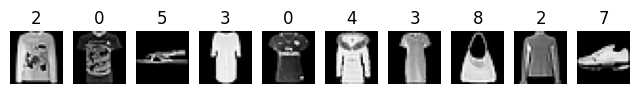

In [5]:
# Visualização
for images, labels in dataloader:
    break
images = images * 0.5 + 0.5

fig, axes = plt.subplots(1, 10, figsize=(8,2))

for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(str(labels[i].item()))
    ax.axis('off')

plt.show()

In [6]:
# Inicialização de pesos
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight.data)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [7]:
# Modelo Generator com camadas convolucionais
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [8]:
# Modelo Discriminator com camadas convolucionais
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [9]:
#instancia o gerador e o discriminador
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

adversarial_loss = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.95)

[Epoch 9/100] [D loss: 0.6511750817298889] [G loss: 0.7177025079727173]


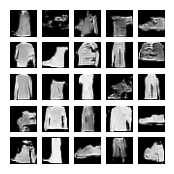

[Epoch 19/100] [D loss: 0.7048127055168152] [G loss: 0.7341729998588562]


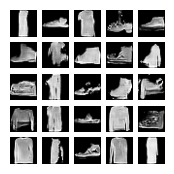

[Epoch 29/100] [D loss: 0.6593632698059082] [G loss: 0.7264062762260437]


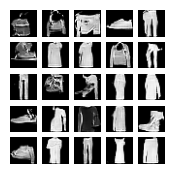

[Epoch 39/100] [D loss: 0.6748881340026855] [G loss: 0.7286772131919861]


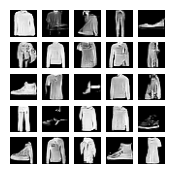

[Epoch 49/100] [D loss: 0.6781442165374756] [G loss: 0.736461341381073]


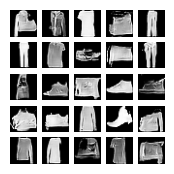

[Epoch 59/100] [D loss: 0.6868429183959961] [G loss: 0.7748236060142517]


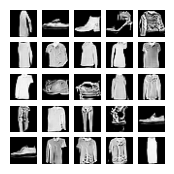

[Epoch 69/100] [D loss: 0.6726498007774353] [G loss: 0.7453967928886414]


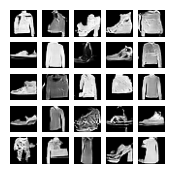

[Epoch 79/100] [D loss: 0.675118088722229] [G loss: 0.7632104158401489]


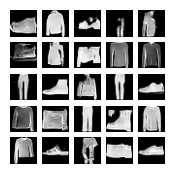

[Epoch 89/100] [D loss: 0.6815914511680603] [G loss: 0.714434027671814]


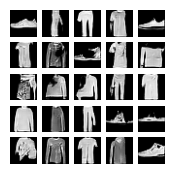

[Epoch 99/100] [D loss: 0.6761499643325806] [G loss: 0.7383064031600952]


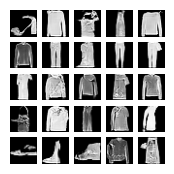

In [11]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = imgs.to(device)
        real_label = torch.FloatTensor(imgs.size(0), 1).uniform_(0.9, 1.0).to(device)
        fake_label = torch.FloatTensor(imgs.size(0), 1).uniform_(0.0, 0.1).to(device)

        # Treinamento do Generator
        optimizer_G.zero_grad()

        #ruído latente
        z = torch.FloatTensor(imgs.size(0), latent_dim).uniform_(-1.0, 1.0).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), real_label)
        g_loss.backward()
        optimizer_G.step()

        # Treinamento do Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_label)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        batches_done = epoch * len(dataloader) + i

    if (epoch + 1) % sample_interval == 0 or epoch == n_epochs - 1:
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
        # Exibe as imagens geradas em vez de salvar em um arquivo
        gen_imgs = gen_imgs.cpu().detach().numpy()  # Move para CPU e converte para NumPy array
        gen_imgs = 0.5 * gen_imgs + 0.5  # Desnormaliza para [0,1]
        gen_imgs = np.squeeze(gen_imgs)  # Remove dimensão de canal se for 1 (para imagens em escala de cinza)

        fig, axs = plt.subplots(5, 5, figsize=(2, 2))
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray' if channels == 1 else None)
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

    # Atualizar learning rate
    scheduler_G.step()
    scheduler_D.step()

# Salvar os modelos
torch.save(generator.state_dict(), "fashion_generator.pth")
#discriminador
#torch.save(discriminator.state_dict(), "fashion_discriminator.pth")


In [12]:
torch.save(generator.state_dict(), "fashion_generator.pth")